In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from davitpy import utils
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,7,5)
timeStart = datetime.datetime(2011,7,5,3,0)
selTime = datetime.datetime(2011,7,5,5,0) 
timeEnd = datetime.datetime(2011,7,5,7,0)
azimCutoff = 30.
plotMlatRange = [ 55., 70. ]
velScale = [ 0., 500. ]
saisVelCutoff = 50.
# Plotting SAPS vels arrows
arrowLenFactor = 8
coords = "mlt"

In [3]:
## Read AMPERE data
ampFName = "../data/" + eventDate.strftime("%Y%m%d") + ".0000.86400.120.north.grd.ncdf"
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-07-05,2011-07-05 00:10:00,89.0,0.0,116.269997,-4.400000,116.180000,6.240000,-10.97,-0.38
1,2011-07-05,2011-07-05 00:10:00,88.0,0.0,113.419998,-33.169998,116.650002,-18.940001,-1.73,-0.30
2,2011-07-05,2011-07-05 00:10:00,87.0,0.0,103.150002,-50.740002,109.480003,-35.049999,6.87,-0.12
3,2011-07-05,2011-07-05 00:10:00,86.0,0.0,92.389999,-47.840000,98.949997,-32.160000,11.60,0.03
4,2011-07-05,2011-07-05 00:10:00,85.0,0.0,85.080002,-30.680000,89.099998,-15.510000,9.72,0.07


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


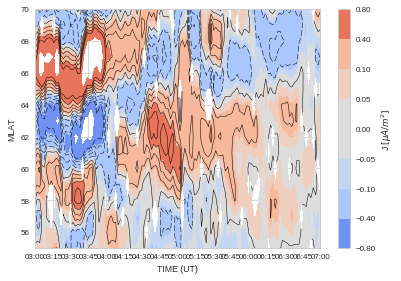

In [4]:
# Some temp constants
plotMltChsn = 22
if plotMltChsn > 12:
    pltNormMLTChsn = plotMltChsn - 24.
else:
    pltNormMLTChsn = plotMltChsn
plotJrCutoff = 0.01
plotJrMin = -0.4
plotJrMax = 0.4
ticks = [ -0.8, -0.4, -0.1, -0.05, 0, 0.05, 0.1, 0.4, 0.8 ]
colNorm = Normalize( vmin=velScale[0], vmax=velScale[1] )
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plotting
seaMap = ListedColormap(sns.color_palette("coolwarm",11))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= timeStart) & (ampDF["start_date"] <= timeEnd) &\
                    (ampDF["mlt"] == plotMltChsn) & (numpy.abs(ampDF["Jr"])>=plotJrCutoff) &\
              (ampDF["mlat"] >= plotMlatRange[0]) & (ampDF["mlat"] <= plotMlatRange[1]) )]

selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]

plotAmpDF = selDF[ ["mlat", "time",\
                        "Jr"] ].pivot( "mlat", "time" )
mlatVals = plotAmpDF.index.values
timeVals = plotAmpDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
jrVals = numpy.ma.masked_where(numpy.isnan(plotAmpDF["Jr"].values),plotAmpDF["Jr"].values)

ampPlot = ax.contourf(timeCntr, mlatCntr,jrVals.T, ticks,cmap=seaMap)
ax.contour(timeCntr, mlatCntr,jrVals.T, numpy.linspace(-0.5, 0.5, 9),
                 origin='lower',
                 linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label(r"J $ [\mu A/m^{2}]$")

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data
velColors = [ "#feebe2", "#fbb4b9", "#f768a1", "#c51b8a", "#7a0177" ]
# ax.scatter( selMltFitsDF["date"].values, selMltFitsDF["medLat"].values,\
#            c=selMltFitsDF["velSAPS"].values, s=selMltFitsDF["velSAPS"].values/3.,\
#           cmap=ListedColormap(sns.light_palette("Purple")), alpha=0.75)

ax.set_xlim( [timeStart, timeEnd] )
ax.set_ylim( plotMlatRange )

ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
seaMap = ListedColormap( sns.light_palette("green") )

fig.savefig( "../plots/ampRTI-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

(734323.125, 734323.2916666666)

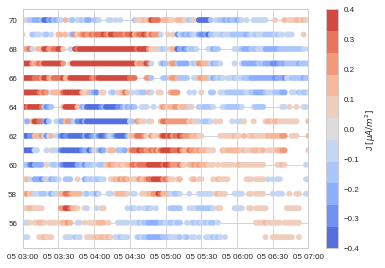

In [5]:
seaMap = ListedColormap(sns.color_palette("coolwarm",11))
plotJrCutoff = 0.05
plotJrMin = -0.4
plotJrMax = 0.4
plotMltChsn = 21
if plotMltChsn > 12:
    pltNormMLTChsn = plotMltChsn - 24.
else:
    pltNormMLTChsn = plotMltChsn

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= timeStart) & (ampDF["start_date"] <= timeEnd) &\
                    (ampDF["mlt"] == plotMltChsn) & (numpy.abs(ampDF["Jr"])>=plotJrCutoff) &\
              (ampDF["mlat"] >= plotMlatRange[0]) & (ampDF["mlat"] <= plotMlatRange[1]) )]

ampSctPlt = ax.scatter(selDF["start_date"].values, selDF["mlat"].values,\
           c=selDF["Jr"].values, cmap=seaMap, vmin=plotJrMin, vmax=plotJrMax)

cbar = plt.colorbar(ampSctPlt)
cbar.set_label(r"J $ [\mu A/m^{2}]$")
ax.set_xlim( [timeStart, timeEnd] )


In [6]:
mltSCWList = [ 20., 21., 22., 23., 0., 1. ]
# jr Cutoff
jrSCWCutoff = 0.0
# MLAT Limit
mlatSCWRng = [ 55., 65. ]
# Max/Min latitude at which you expect 
# to find downward FACs associated with SCW
scwDownMlatRange = [ 55, 62. ]
delTime = datetime.timedelta(minutes=2)
# We'll take a simple approach to determine 
# We'll determine the largest positive current
# value between 50 and 70 MLAT (at a few selected
# MLTs). This should be upward R2 FAC. Then largest 
# downward FAC equatorward of this value is the peak
# of downward component of the SCW!

scwLocDates = []
scwLocMlatDown = []
scwLocMlatUp = []
scwMLTDown = []
scwMLTUp = []
scwJrDown = []
scwJrUp = []

currDate = timeStart
while currDate <= timeEnd:
    currMinJr = 0.
    currMaxJr = 0.
    currMinMlat = 0.
    currMaxMlat = 0.
    currMinMLT = 0.
    currMaxMLT = 0.
    for cMlt in mltSCWList:
        selDF = ampDF[ ( (ampDF["start_date"] == currDate) &\
                        (numpy.abs(ampDF["Jr"])>=jrSCWCutoff) &\
                       (ampDF["mlt"] == cMlt) &\
                   (ampDF["mlat"] >= mlatSCWRng[0]) &\
                        (ampDF["mlat"] <= mlatSCWRng[1])) ]\
                [ ["start_date", "mlat", "mlt", "Jr"] ].reset_index(drop=True)
        if selDF.shape[0] == 0:
            print "no data found selDF"
            continue
#         if currDate == selDate:
#         print currDate, cMlt
        maxUpJrMlt = selDF.ix[ selDF["Jr"].idxmax() ]["mlt"]
        maxUpJrMlat = selDF.ix[ selDF["Jr"].idxmax() ]["mlat"]
        maxUpJrVal = selDF.ix[ selDF["Jr"].idxmax() ]["Jr"]
#         print "---------------------------"
#         print maxUpJrMlt,maxUpJrMlat,maxUpJrVal
        scwDownDF = selDF[ selDF["mlat"] < maxUpJrMlat ]
        if scwDownDF.shape[0] == 0:
            print "no data found selDF"
            continue
        minDownSCWMlat = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["mlat"]
        minDownSCWJr = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["Jr"]
        minDownSCWMlt = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["mlt"]
        if minDownSCWJr > 0.:
            print "postive val found for Jscw down, discarding!"
            continue
        if ( (minDownSCWMlat > scwDownMlatRange[1]) | (minDownSCWMlat < scwDownMlatRange[0]) ) :
            print "downward scw FACs location may not be good, skipping"
            continue
#         print minDownSCWMlt,minDownSCWMlat,minDownSCWJr
        scwLocDates.append( currDate )
        scwLocMlatDown.append( minDownSCWMlat )
        scwLocMlatUp.append( maxUpJrMlat )
        scwMLTDown.append( minDownSCWMlt )
        scwMLTUp.append( maxUpJrMlt )
        scwJrDown.append( minDownSCWJr )
        scwJrUp.append( maxUpJrVal )
    currDate += delTime
    
# convert fit results to a dataframe
ampSCWDF = pandas.DataFrame(
     {'scwLocDates': scwLocDates,
     'scwLocMlatDown': scwLocMlatDown,
     'scwLocMlatUp': scwLocMlatUp,
     'scwMLTDown': scwMLTDown,
     'scwMLTUp': scwMLTUp,
     'scwJrDown': scwJrDown,
     'scwJrUp': scwJrUp,
    })
# Discard zero vals (those which were initiated)
# but never used
ampSCWDF = ampSCWDF[ ampSCWDF["scwLocMlatDown"] > 0.].reset_index(drop=True)
# write results to dataframe
feather.write_dataframe(ampSCWDF, '../data/amp-scw-' +\
                eventDate.strftime("%Y%m%d") + '.feather')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


downward scw FACs location may not be good, skipping
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
downward scw FACs location may not be good, skipping
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
downward scw FACs location may not be good, skipping
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
downward scw FACs location may not be good, skipping
postive val found for Jscw down, discarding!
downward scw FACs location may not be good, skipping
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
postive val found for Jscw down, discarding!
downward scw FACs location may not be good, skipping
no data

In [7]:
ampSCWDF.head()

,scwJrDown,scwJrUp,scwLocDates,scwLocMlatDown,scwLocMlatUp,scwMLTDown,scwMLTUp
0,-0.49,0.15,2011-07-05 03:00:00,60.0,64.0,20.0,20.0
1,-0.47,0.57,2011-07-05 03:00:00,61.0,65.0,21.0,21.0
2,-0.16,0.48,2011-07-05 03:00:00,56.0,60.0,23.0,23.0
3,-0.06,0.37,2011-07-05 03:00:00,56.0,60.0,0.0,0.0
4,-0.11,0.48,2011-07-05 03:00:00,56.0,60.0,1.0,1.0


/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


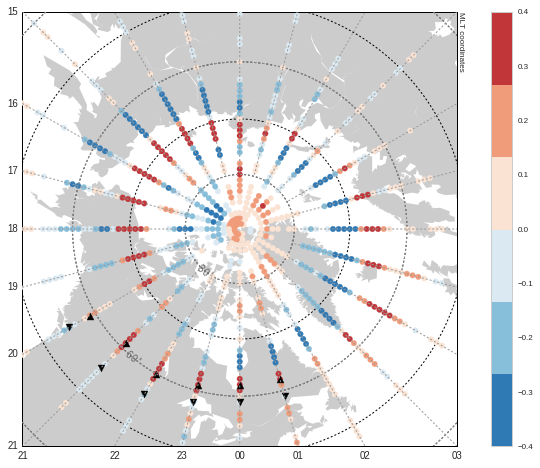

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)

seaMap = ListedColormap(sns.color_palette("RdBu_r"))

plotAmpDF = ampDF[ (ampDF["start_date"] == selTime) &\
                 (numpy.abs(ampDF["Jr"]) >= 0.05) ]

# plotAmpDF = plotAmpDF[ ["mlt", "mlat",\
#                         "Jr"] ].pivot( "mlt", "mlat" )
# mltVals = plotAmpDF.index.values*15.
# mlatVals = plotAmpDF.columns.levels[1].values
# mltCntr, mlatCntr  = numpy.meshgrid( mltVals, mlatVals )



mapHandle = utils.plotUtils.mapObj(boundinglat=50., coords=coords,\
                                   lat_0=90., lon_0=0, datetime=selTime)
parallels = numpy.arange(0.,81,10.)
mapHandle.drawparallels(parallels)
# xVecs, yVecs = mapHandle(mltCntr, mlatCntr, coords=coords)
xVecs, yVecs = mapHandle(plotAmpDF["mlt"].values*15., plotAmpDF["mlat"].values, coords=coords)
ampPlot = mapHandle.scatter( xVecs, yVecs, c=plotAmpDF["Jr"].values, zorder=7., cmap=seaMap, ax=ax, vmin=-0.4,vmax=0.4 )
# ampPlot = mapHandle.contourf( xVecs, yVecs, plotAmpDF["Jr"].values.T, zorder=7., cmap=seaMap, ax=ax, vmin=-0.4,vmax=0.4 )

##### PLOT SCW ####
##### PLOT SCW ####
scwDwnMlat = ampSCWDF[ ampSCWDF["scwLocDates"] == selTime ]["scwLocMlatDown"].values
scwDwnMLT = ampSCWDF[ ampSCWDF["scwLocDates"] == selTime ]["scwMLTDown"].values
scwUpMlat = ampSCWDF[ ampSCWDF["scwLocDates"] == selTime ]["scwLocMlatUp"].values
scwUpMLT = ampSCWDF[ ampSCWDF["scwLocDates"] == selTime ]["scwMLTUp"].values

xVecDwn, yVecDwn = mapHandle(scwDwnMLT*15., scwDwnMlat, coords=coords)
xVecUp, yVecUp = mapHandle(scwUpMLT*15., scwUpMlat, coords=coords)

mapHandle.scatter( xVecDwn, yVecDwn, marker='v', s=50, c='k', ax=ax, zorder=8 )
mapHandle.scatter( xVecUp, yVecUp, marker='^', s=50, c='k',ax=ax, zorder=8 )

##### PLOT SCW ####
##### PLOT SCW ####

cbar = plt.colorbar(ampPlot, orientation='vertical')

(734323.125, 734323.2916666666)

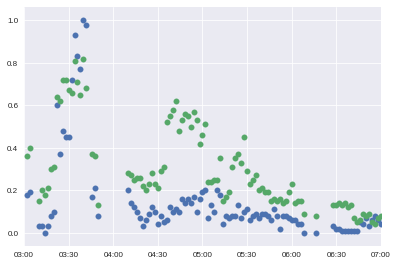

In [9]:
pltSCWDF = ampSCWDF[ ampSCWDF["scwMLTDown"] == 22 ]
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
# figure
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.scatter( pltSCWDF['scwLocDates'].values, numpy.abs(pltSCWDF['scwJrDown'].values) )
ax.scatter( pltSCWDF['scwLocDates'].values, pltSCWDF['scwJrUp'].values )
# ax.plot( fitsDF["date"].values, fitsDF["velSAPS"].values, 'o' )
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.set_xlim( [timeStart, timeEnd] )
# fig1.savefig("../plots/amp-ts-20110608.pdf",bbox_inches='tight')

(734323.125, 734323.2916666666)

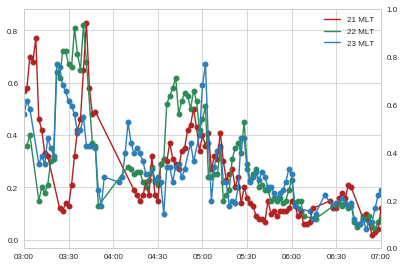

In [11]:
selMLTs = [21, 22, 23]
sns.set_style("whitegrid")
sns.set_context("paper")
colList = [ "firebrick", "seagreen", "#2c7fb8" ]

fig = plt.figure()
ax = fig.add_subplot(111)

ax2 = ax.twinx()

for nm, mm in enumerate(selMLTs):
    selAmpDF = ampSCWDF[ ampSCWDF["scwMLTDown"] == mm ]
    if mm > 12.:
        normM = mm -24.
    else:
        normM = mm
#     selVelDF = fitsDF[ fitsDF["mltSAPS"] == normM ]
    # plot AMP
    ax.plot( selAmpDF["scwLocDates"].values, numpy.abs(selAmpDF["scwJrUp"].values), color=colList[nm], label=str(mm) + " MLT" )
    ax.scatter( selAmpDF["scwLocDates"].values, numpy.abs(selAmpDF["scwJrUp"].values), color=colList[nm])
    # plot VELS
#     ax2.plot( selVelDF["date"].values, selVelDF["velSAPS"].values, color=colList[nm] )
#     ax2.scatter( selVelDF["date"].values, selVelDF["velSAPS"].values, color=colList[nm], marker="*" )

ax.legend()
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
ax2.grid('off')

ax.set_xlim( [timeStart, timeEnd] )
# fig.savefig( "../plots/amp-vel-ts-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )